# Chinese Restaurant Recommendation in New York

There are large number of people especially for travelers are desire to find the most appropriate restaurants in big city. However, the miscellaneous info on the web contain different noise and interfere the people's choice. These kind of info not only based on the gourmet's review and the numbers of order, but also contain the malicious comments from other competitors. Consequently, in this project, we will identify the several different Chinese restaurants in New York based on location 

In [2]:
#First, set up the environment, necessary libraries and dependencies
import pandas as pd
import numpy as np
import requests

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
import io
from io import BytesIO

!conda update -n base -c defaults conda

#library to deal with JSON files
import json 

#tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

#convert an address into latitude and longitude values
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

#map rendering library
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

In [3]:
#Acquring geo address and location
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    
    #the variables should be as the following:
    radius=600
    LIMIT=150
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    #get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    #acquring the entire data
    results = requests.get(url).json() 
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_nyc_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json() # all data is in features label
    
    features=resp['features'] # define the dataframe columns
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']  # instantiate the dataframe
    
    nyc_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        nyc_data = nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return nyc_data

Get NYC geographic data.

In [4]:
nyc_data = get_nyc_data()
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [47]:
nyc_data.shape

(306, 4)

Review our initial data by creating a bar plot to look at the distribution of neigborhoods per borough.
We can see that Queens has the greatest number of neighborhoods and Manhattan has the least.

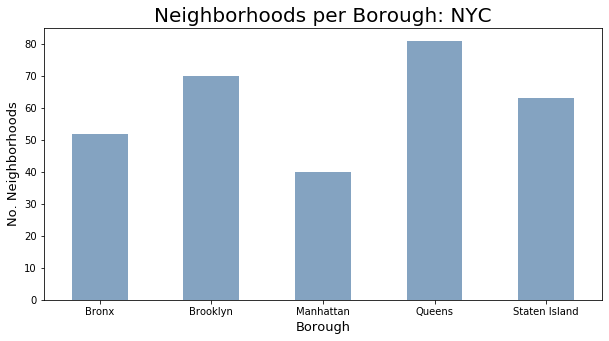

In [5]:
gry = 0.2, 0.4, 0.6, 0.6
nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=gry)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 13)
plt.ylabel('No. Neighborhoods',fontsize = 13)
plt.xticks(rotation = 'horizontal')
plt.show()

Now we will look at how many Chinese restaurants there are in each of the boroughs and neighborhoods.

In [114]:
#Create a data frame that contains number of chinese restaurants per neighborhood using foursquare api call function get_venues.

column_names=['Borough', 'Neighborhood', 'ID','Name']
chi_res_nyc=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chi_res=venues[venues['Category']=='Chinese Restaurant']   
    #print('(',count,'/',len(nyc_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chi_res)))
    #print(row)
    for rest_detail in chi_res.values.tolist():
        id, name , category=rest_detail
        chi_res_nyc = chi_res_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
  

In [16]:
chi_res_nyc.shape

(269, 4)

In [20]:
#save data to limit Foursquare calls
project.save_data("chinese restaurants nyc.csv", chi_res_nyc.to_csv(), overwrite=True)


{'file_name': 'chinese restaurants nyc.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'adscapstoneprojectasianbistroanal-donotdelete-pr-clrcdigez8xpsd',
 'asset_id': '04e0fac3-b7d9-47d0-91fd-8e9ebe4be434'}

In [6]:
chi_res_nyc = r'chinese restaurants nyc.csv'
chi_res_nyc = pd.read_csv(chi_res_nyc)
chi_res_nyc.head()
chi_res_nyc.drop(['Unnamed: 0'], axis=1, inplace = True)

In [31]:
chi_res_nyc.tail()

,Borough,Neighborhood,ID,Name
264,Brooklyn,Homecrest,4d28b924ebacb1f72efbf34f,Wing Hing Seafood Restaurant
265,Brooklyn,Madison,4be32bd7b02ec9b61fc34ec0,win hing
266,Bronx,Bronxdale,4c3f7f2eda3dc928b8f6c5b9,Peking Kitchen
267,Bronx,Allerton,4bc11181abf495219f7dc093,Li's Kitchen
268,Queens,Hammels,4c72ad2bad69b60cb31b84b9,301 Chinese Resturant


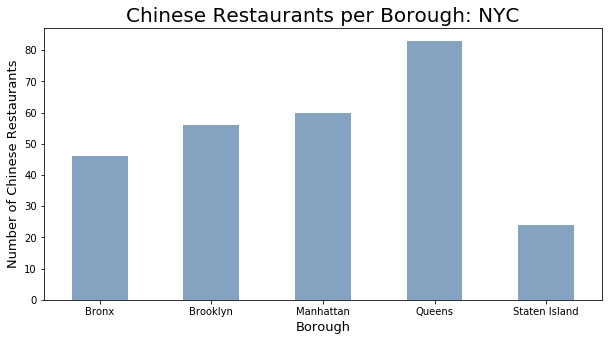

In [7]:
chi_res_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = gry )
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 13)
plt.ylabel('Number of Chinese Restaurants', fontsize=13)
plt.xticks(rotation = 'horizontal')
plt.show()

In [25]:
chi_res_nyc.set_index(['Borough', 'Neighborhood']).count(level='Borough')

,ID,Name
Borough,,
Bronx,46,46
Brooklyn,56,56
Manhattan,60,60
Queens,83,83
Staten Island,24,24


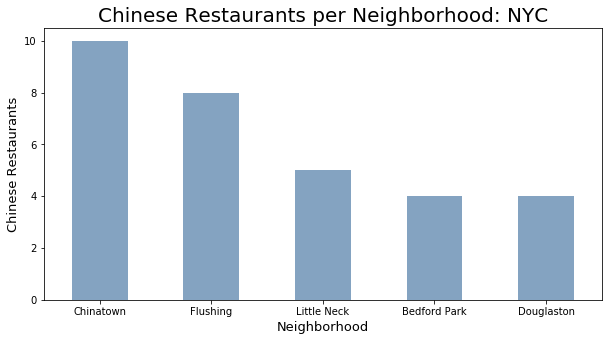

In [64]:
#Top 5 Neighborhoods with largest number of Chinese restaurants.
NofNeigh = 5
chi_res_nyc.groupby('Neighborhood')['ID'].count().nlargest(NofNeigh).plot.bar(figsize=(10,5), color=gry)
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 13)
plt.ylabel('Chinese Restaurants', fontsize=13)
plt.xticks(rotation = 'horizontal')
plt.show()

Queens has the greatest number of Chinese restaurants per borough in NYC however, Chinatown in Manhattan has 
the highest number of Chinese restaurants per neighborhood.

In [45]:
chi_res_nyc[chi_res_nyc['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
81,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
82,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
83,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店
84,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
85,Manhattan,Chinatown,3fd66200f964a52067e61ee3,Joe's Shanghai 鹿嗚春
86,Manhattan,Chinatown,46936ee3f964a520d0481fe3,Shanghai Café Deluxe
87,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
88,Manhattan,Chinatown,3fd66200f964a520ede41ee3,Big Wong King 大旺
89,Manhattan,Chinatown,59ad625a2619ee5cdded881f,House Special 甘來飯店
90,Manhattan,Chinatown,3fd66200f964a520ceea1ee3,Deluxe Green Bo Restaurant


In [ ]:
#make a call to Foursquare API to get Likes and Rating 

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating']
chi_rest_stats_nyc=pd.DataFrame(columns=column_names)
count=1
for row in chi_res_nyc.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating=venue_details.values.tolist()[0]
    except IndexError:
        #print('No data available for id=',ID) #assign 0 value for the restaurants as they may have been
                                            #recently opened or details do not exist in the FourSquare Database
        id,name,likes,rating=[0]*4                                                                                   
    #print('(',count,'/',len(chi_res_nyc),')','processed')
    chi_rest_stats_nyc = chi_rest_stats_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                },ignore_index=True)
                                                                                             
                                        
                                               
    count+=1


In [33]:
chi_rest_stats_nyc.shape

(269, 6)

In [34]:
#save data to limit Foursquare calls
project.save_data("chinese restaurants stats nyc.csv", chi_rest_stats_nyc.to_csv(), overwrite=True)

{'file_name': 'chinese restaurants stats nyc.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'adscapstoneprojectasianbistroanal-donotdelete-pr-clrcdigez8xpsd',
 'asset_id': 'c6c329f9-c830-4f6a-8bd0-0cb1809997c2'}

In [17]:
chi_rest_stats_nyc = r'chinese restaurants stats nyc.csv'

chi_rest_stats_nyc = pd.read_csv(chi_rest_stats_nyc)
chi_rest_stats_nyc.drop(['Unnamed: 0'], axis=1, inplace = True)
chi_rest_stats_nyc.head()

,Borough,Neighborhood,ID,Name,Likes,Rating
0,Bronx,Eastchester,0,0,0,0.0
1,Bronx,Kingsbridge,0,0,0,0.0
2,Bronx,Woodlawn,0,0,0,0.0
3,Bronx,Norwood,0,0,0,0.0
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.4


In [30]:
#drop rows with zero ratings
indexratingzero=chi_rest_stats_nyc[chi_rest_stats_nyc['Rating']==0].index
chi_rest_stats_nyc.drop(indexratingzero, inplace=True)
chi_rest_stats_nyc.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating
263,Brooklyn,Homecrest,4b46743ff964a520892126e3,"Golden ""Z"" Restaurant",9,7.6
264,Brooklyn,Homecrest,4d28b924ebacb1f72efbf34f,Wing Hing Seafood Restaurant,25,6.7
266,Bronx,Bronxdale,4c3f7f2eda3dc928b8f6c5b9,Peking Kitchen,9,7.4
267,Bronx,Allerton,4bc11181abf495219f7dc093,Li's Kitchen,2,7.1
268,Queens,Hammels,4c72ad2bad69b60cb31b84b9,301 Chinese Resturant,9,6.3


In [31]:
chi_rest_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 4 to 268
Data columns (total 6 columns):
Borough         162 non-null object
Neighborhood    162 non-null object
ID              162 non-null object
Name            162 non-null object
Likes           162 non-null int64
Rating          162 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 8.9+ KB


In [6]:
#look at the statistics of the table for likes, ratings
chi_rest_stats_nyc.describe()

,Likes,Rating
count,162.000000,162.000000
mean,111.648148,7.512346
std,241.576820,0.943284
min,0.000000,5.400000
25%,6.000000,6.800000
50%,16.000000,7.600000
75%,70.000000,8.200000
max,1473.000000,9.200000


In [52]:
#check restaurant with max likes and rating
chi_rest_stats_nyc.loc[chi_rest_stats_nyc['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1473
Rating                               9.2
Name: 117, dtype: object

In [32]:
#create dataframe with average ratings per Neighborhood


neighborhood_stats = chi_rest_stats_nyc.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']
neighborhood_stats.sort_values(['Average Rating'], ascending=False).head()


,Neighborhood,Average Rating
33,Flatiron,9.20
15,Chelsea,9.20
88,West Village,8.95
60,Midtown South,8.90
42,Greenwich Village,8.90


In [33]:
#create dataframe with average ratings per borough
borough_stats=chi_rest_stats_nyc.groupby('Borough', as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough', 'Average Rating']
borough_stats.sort_values(['Average Rating'], ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.062069
1,Brooklyn,7.436364
3,Queens,7.184615
4,Staten Island,6.922222
0,Bronx,6.810000


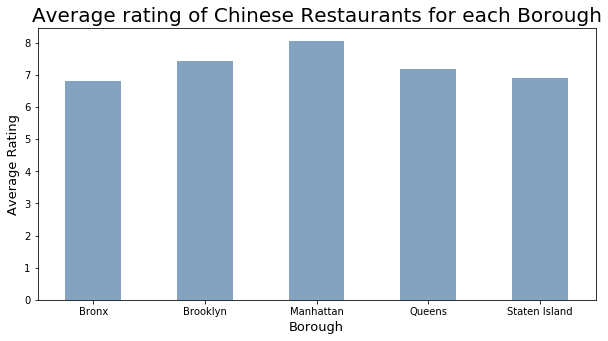

In [34]:
#plot the average rating per borough
borough_stats.groupby('Borough').mean()['Average Rating'].plot.bar(figsize=(10,5), color=gry)
plt.title('Average rating of Chinese Restaurants for each Borough', fontsize=20)
plt.xlabel('Borough',fontsize=13)
plt.ylabel('Average Rating', fontsize=13)
plt.xticks(rotation='horizontal')
plt.show()

We will map the neighborhoods with an average rating greater than or equal to 6 after joining the appropriate dataframes with geolocation data.

In [35]:
#create dataframe with average rating greater than 6
neighborhood_stats_rating = neighborhood_stats[neighborhood_stats['Average Rating']>=6.0]
neighborhood_stats_rating.shape

(88, 2)

In [36]:
#merge ratings df with lat and long
neighborhood_stats_rating = pd.merge(neighborhood_stats_rating, nyc_data, on='Neighborhood')
neighborhood_stats_rating=neighborhood_stats_rating[['Borough', 'Neighborhood','Latitude','Longitude','Average Rating']]
neighborhood_stats_rating.tail()


,Borough,Neighborhood,Latitude,Longitude,Average Rating
86,Staten Island,Westerleigh,40.621090,-74.133041,7.25
87,Brooklyn,Williamsburg,40.707144,-73.958115,8.20
88,Brooklyn,Windsor Terrace,40.656946,-73.980073,8.90
89,Queens,Woodside,40.746349,-73.901842,8.30
90,Manhattan,Yorkville,40.775930,-73.947118,7.70


In [46]:
#geo_location is malfunction below NYC coordinates from Google
latitude= 40.687936
longitude= -73.976358

#create map with neighborhoods and rating
from folium import plugins

#start with clean copy of NYC map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

#instantiate a marker cluster object for the ratings in the dataframe
chi_rating = plugins.MarkerCluster().add_to(nyc_map)

neighborhood_stats_rating['Label']= neighborhood_stats_rating['Neighborhood']+'('+neighborhood_stats_rating['Average Rating'].map(str)+')'
#loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in neighborhood_stats_rating[['Latitude','Longitude','Label']].values:
    folium.Marker(
        location=[lat,lng],
        icon=None,
        popup=label).add_to(chi_rating)
    
  
#display map
nyc_map
                                           
                                           


In [19]:
neighborhood_stats_rating.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Bronx,Allerton,40.865788,-73.859319,7.10,Allerton(7.1)
1,Queens,Astoria,40.768509,-73.915654,7.70,Astoria(7.7)
2,Brooklyn,Bath Beach,40.599519,-73.998752,6.60,Bath Beach(6.599999999999999)
3,Brooklyn,Bay Ridge,40.625801,-74.030621,7.35,Bay Ridge(7.35)
4,Bronx,Bedford Park,40.870185,-73.885512,6.45,Bedford Park(6.449999999999999)


We will visualize the average rating for all Buroughs with a choropleth map.

In [38]:
#generating the choropleth map in terms of average rating per borough
nyc_geo = r'Borough Boundaries.geojson'
nyc_map = folium.Map(location=[latitude,longitude], zoom_start=11)

nyc_map.choropleth(
    geo_data=nyc_geo,
    name='choropleth',
    data=borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

nyc_map.save('avg_rating_borough.html')